In [1]:
import os
import cv2
import glob
import timm
import random
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import mean_squared_error, mean_absolute_error, accuracy, f1_score

batch_size = 256

df = pd.read_excel("data/US_fibrosis_stage_dataset.xlsx", engine="openpyxl")
# only HBV patients
df = df[df.Etiology == 1].reset_index(drop=True)
df = df.loc[(df.AST < 100) | (df.ALT < 100)].reset_index(drop=True)
df = df.loc[:, ["ID", "kPa_fib"]].dropna().reset_index(drop=True)

df.ID = df.ID.map(lambda x: str(x).zfill(8))

def generate_target(x):
    if x >= 11:
        return 1
    else:
        return 0

df.loc[:, "target"] = df.kPa_fib.map(generate_target)

flist = os.listdir("data/roi_sampled/")
id_list = list(map(lambda x: x.split("_")[0].zfill(8), flist))

image_df = pd.DataFrame(glob.glob(os.path.join("data", "roi_sampled", "*.jpg")), columns=["image_path"])
image_df.loc[:, "ID"] = image_df.image_path.map(lambda x: x.split("/")[-1].split("-")[0])

df = pd.merge(df, image_df, on="ID", how="inner")
df.head()

,ID,kPa_fib,target,image_path
0,00596618,6.1,0,data/roi_sampled/00596618-0.jpg
1,00596618,6.1,0,data/roi_sampled/00596618-1.jpg
2,00596618,6.1,0,data/roi_sampled/00596618-10.jpg
3,00596618,6.1,0,data/roi_sampled/00596618-11.jpg
4,00596618,6.1,0,data/roi_sampled/00596618-12.jpg


In [2]:
ids = df.loc[:, ["ID", "target"]].drop_duplicates().reset_index(drop=True)

train_id, test_id = train_test_split(ids, test_size=0.15, stratify=ids.target, random_state=42)
train_id, valid_id = train_test_split(train_id, test_size=0.15, stratify=train_id.target, random_state=42)

train_df = df[df.ID.isin(train_id.ID)].reset_index(drop=True)
valid_df = df[df.ID.isin(valid_id.ID)].reset_index(drop=True)
test_df = df[df.ID.isin(test_id.ID)].reset_index(drop=True)

print("Train: ", len(train_df.ID.drop_duplicates()), "&", dict(Counter(train_df.target)))
print("Valid: ", len(valid_df.ID.drop_duplicates()), "&", dict(Counter(valid_df.target)))
print("Test: ", len(test_df.ID.drop_duplicates()), "&", dict(Counter(test_df.target)))

Train:  264 & {0: 4296, 1: 562}
Valid:  47 & {0: 854, 1: 97}
Test:  56 & {0: 840, 1: 100}


In [3]:
from typing import Callable

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices: a list of indices
        num_samples: number of samples to draw
        callback_get_label: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(
        self,
        dataset,
        labels: list = None,
        indices: list = None,
        num_samples: int = None,
        callback_get_label: Callable = None,
    ):
        # if indices is not provided, all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) if indices is None else indices

        # define custom callback
        self.callback_get_label = dataset.df.target

        # if num_samples is not provided, draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        # distribution of classes in the dataset
        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset) if labels is None else labels
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [4]:
def define_augmentation(w, h):
    train_transforms = A.Compose([ 
        A.Resize(width=w, height=h, p=1.0),
        A.OneOf([
            A.Downscale(),
        ], p=0.5),        
        
        A.HorizontalFlip(p=0.5),
        
        A.Affine(p=0.8),
        
        A.OneOf([
            A.RandomBrightnessContrast(),
            A.RandomBrightness(),
            A.RandomContrast()
        ], p=0.5),
        
        A.Normalize(p=1.0),
        ToTensorV2()
    ])

    valid_transforms = A.Compose([ 
        A.Resize(width=w, height=h, p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2()
    ])

    return train_transforms, valid_transforms


class SonographyDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.loc[idx, "image_path"])
        image = self.transform(image=image)
        
        y = self.df.loc[idx, "target"]

        return image['image'], torch.tensor(y).long()
    
    
train_transform, valid_transform = define_augmentation(w=256, h=256)

train_dataset = SonographyDataset(train_df, train_transform)
valid_dataset = SonographyDataset(valid_df, valid_transform)
test_dataset = SonographyDataset(test_df, valid_transform)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, 
                              num_workers=12, prefetch_factor=10,
                              pin_memory=True, sampler=ImbalancedDatasetSampler(train_dataset, labels=train_dataset.df.target))

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=12, prefetch_factor=10,
                              pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, 
                              num_workers=12, prefetch_factor=10,
                              pin_memory=True)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [5]:
# https://github.com/clcarwin/focal_loss_pytorch/blob/master/focalloss.py
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

        
gamma = 2.5
   
        
class FibrosisPredictor(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        
    def forward(self, x):
        return self.model(x)
    
    
    def step(self, batch):
        x, y = batch
        logits = self(x)
        loss = FocalLoss(gamma=gamma)(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        
        return logits, loss, acc
    
    
    def training_step(self, batch, batch_idx):
        _, loss, acc = self.step(batch)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        _, loss, acc = self.step(batch)
        
        self.log('valid_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        
    
    def test_step(self, batch, batch_idx):
        _, loss, acc = self.step(batch)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', accuracy(preds, y), on_step=False, on_epoch=True, prog_bar=True)
    
    
    def predict_step(self, batch, batch_idx):
        logits, _, _ = self.step(batch)
        
        return logits

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
    
    def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
        scheduler.step(epoch=self.current_epoch)

    
    
callbacks = [
    ModelCheckpoint(monitor='valid_loss', save_top_k=3, dirpath='weights/classification', filename='fibrosis_predictor-{epoch:03d}-{valid_loss:.4f}-{valid_accuracy:.4f}'),
]

model = timm.create_model("resnet50", pretrained=True, num_classes=2)
for n, p in model.named_parameters():
    if n.split(".")[0] in ["layer4", "fc"]:
        p.requires_grad = True
    else:
        p.requires_grad = False
    
fibrosis_predictor = FibrosisPredictor(model)

trainer = pl.Trainer(max_epochs=100, gpus=[0], enable_progress_bar=True, 
                     callbacks=callbacks, precision=16)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:429: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(fibrosis_predictor, train_dataloader, valid_dataloader)

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/ubuntu/Workspace/UltrasonographyImageAnalysis/weights/classification exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
47.024    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1867: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 19it [00:00, ?it/s]

/tmp/ipykernel_15989/273732256.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs.append(F.softmax(p.float()).numpy().tolist())


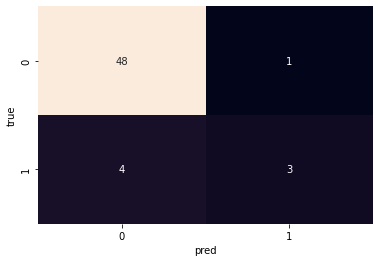

AUC: 0.8163
Acc: 0.9107


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score

ckpt_fname = "fibrosis_predictor-epoch=044-valid_loss=0.0923-valid_accuracy=0.7750.ckpt"
fibrosis_predictor = fibrosis_predictor.load_from_checkpoint("weights/classification/" + ckpt_fname, model=model)

preds = trainer.predict(fibrosis_predictor, test_dataloader)
probs = []

for batch in preds:
    for p in batch:
        probs.append(F.softmax(p.float()).numpy().tolist())

probs = np.array(probs)
test_df.loc[:, "prob_class_1"] = probs[:, 0]
test_df.loc[:, "prob_class_2"] = probs[:, 1]

prob_class_1 = test_df.loc[:, ["ID", "prob_class_1"]].sort_values(["ID", "prob_class_1"]).groupby("ID").head(5).groupby("ID").mean().prob_class_1.values
prob_class_2 = test_df.loc[:, ["ID", "prob_class_2"]].sort_values(["ID", "prob_class_2"]).groupby("ID").head(5).groupby("ID").mean().prob_class_2.values

prob_class = F.softmax(torch.tensor([prob_class_1, prob_class_2]).T, dim=1)
pred_class = torch.argmax(torch.tensor([prob_class_1, prob_class_2]).T, dim=1)

pred_df = test_df.loc[:, ["ID", "target"]].drop_duplicates().reset_index(drop=True)
pred_df.loc[:, "pred_class"] = pred_class
pred_df.loc[:, "prob_class_1"] = prob_class[:, 0]
pred_df.loc[:, "prob_class_2"] = prob_class[:, 1]

sns.heatmap(confusion_matrix(pred_df.target, pred_df.pred_class), annot=True, fmt="d", cbar=False)
plt.xlabel("pred")
plt.ylabel("true")
plt.show()

print(f"AUC: {round(roc_auc_score(pred_df.target, pred_df.prob_class_2), 4)}")
print(f"Acc: {round(accuracy_score(pred_df.target, pred_df.pred_class), 4)}")

In [17]:
import math

df_fib4 = pd.read_excel("data/US_fibrosis_stage_dataset.xlsx", engine="openpyxl")
df_fib4 = df_fib4.loc[(df_fib4.AST < 100) | (df_fib4.ALT < 100)].reset_index(drop=True)
df_fib4 = df_fib4.loc[:, ["ID", "age", "AST", "ALT", "PLT"]].dropna().reset_index(drop=True)
df_fib4.loc[:, "FIB4"] = df_fib4.apply(lambda x: (x['age'] * x['AST']) / (x['PLT'] * math.sqrt(x['ALT'])), axis=1)

df_fib4.ID = df_fib4.ID.map(lambda x: str(x).zfill(8))
df_fib4 = df_fib4.loc[:, ["ID", "FIB4"]].drop_duplicates().reset_index(drop=True)

pred_df = pred_df.merge(df_fib4, on='ID', how="left")
temp_df = pred_df.dropna()

print(f"AUC: {round(roc_auc_score(temp_df.target, temp_df.FIB4), 4)}")

AUC: 0.9009
